## <b>XAI Phishing Detection using Dynamic features</b>
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import datasets, svm, metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from dateutil import parser
import time
import shap

## Importing in Phishing Dataset

In [2]:
phish= pd.read_csv('./phishing_email.csv')
phish.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


## Analysing Raw Data

In [3]:
phish.info()
phish.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


text_combined    False
label            False
dtype: bool

In [4]:
print(phish['label'].value_counts())

label
1    42891
0    39595
Name: count, dtype: int64


## Preprocessing

In [5]:
def preprocessing(text):
    text = text.lower().strip()
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    return text

In [6]:
# Applying Preprocessing to data
phish['processed_data'] = phish['text_combined'].apply(preprocessing)

In [7]:
phish['processed_data'].describe()

count                                                 82486
unique                                                82078
top       charity sees need cost dear friend read want f...
freq                                                      3
Name: processed_data, dtype: object

## Implementing Dynamic Features

In [8]:
# Creating Timestamp extraction function
def extractTimestamps(emailText):

    tPatterns = [
        # Pattern may 25 2001
        r'(\b(?:january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2}\s+\d{4})',
        # Pattern 05 30 12 07 pm
        r'(\d{1,2}\s+\d{1,2}\s+\d{4}\s+\d{1,2}\s+\d{1,2}\s+pm)',
        # Pattern 05 29 2001 08 37
        r'(\d{1,2}\s+\d{1,2}\s+\d{4}\s+\d{1,2}\s+\d{1,2}\s+\d{1,2})',
        # Pattern 05 25 01 (short year format)
        r'(\d{1,2}\s+\d{1,2}\s+\d{2}(?:\s+\d{1,2}\s+\d{1,2})?)',
        # Pattern thursday june 28 2001 9 58
        r'(\b(?:monday|tuesday|wednesday|thursday|friday|saturday|sunday)\s+(?:january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2}\s+\d{4}\s+\d{1,2}\s+\d{1,2})',
        # Pattern 2001 (year only as fallback)
        r'\b((?:19|20)\d{2})\b'
    ]

    # Try each pattern
    for pattern in tPatterns[:-1]:  
        matches = re.findall(pattern, emailText, re.IGNORECASE) # findsall occurences ignoring if upper or lower case
        for match in matches:
            try:
                # Clean up spacing and parsing to datetime format
                clean = re.sub(r'\s+', ' ', match.strip()) # replacing multiple spaces with single space
                pTime = parser.parse(clean, fuzzy=True)
                
                # Validate year
                if 1990 <= pTime.year <= 2020:
                    return pTime  # Return first valid timestamp
            except:
                continue
        
    # If no timestamps found try year pattern
    yearP = re.findall(tPatterns[-1], emailText)
    if yearP:
        try:
            year = int(yearP[0])
            if 1990 <= year <= 2020:
                return datetime.datetime(year, 6, 15, 12, 0) # sets date properly if only year found by defaulting to June 15th at 12
        except:
            pass
    return 

In [20]:
# Creating Session logs
def sessionLogs(text, timestamp):
    
    # empty list for holding text chunks
    segments = []
    
    # Punctuation based splitting
    if re.search(r'[.!?;:]', text):
        natural_splits = re.split(r'[.!?;:]+', text)
        natural_splits = [s.strip() for s in natural_splits if len(s.strip()) > 10]
        
        # If natural segments are reasonable use
        if 3 <= len(natural_splits) <= 20:
            segments = natural_splits
    
    # Fallback to adaptive chunking if not proper punctuation found
    if not segments:
        words = text.split()
        
        if len(words) == 0:
            return []  # No words to process
        
        # Segment chunking of enuring at least 3 segments per email
        target_segments = max(3, len(words) // 15) # 15 words per chunk, while ensuring least 3 segments 
        chunk_size = max(1, len(words) // target_segments)  # words per chunk 
        
        # Creates the segments
        for i in range(0, len(words), chunk_size):
            chunk = ' '.join(words[i:i + chunk_size])
            if len(chunk.strip()) > 5: #filtering out chunks less than 5 letters
                segments.append(chunk)
    
    # Use full text if less than 5 words
    if not segments:
        segments = [text]
    
    sessions = [] # Empty list to store logs
    currentTime = timestamp

    # Processing each sentence
    for i, segment in enumerate(segments):
        processed = preprocessing(segment)
        
        # Calculate reading time 
        word_count = len(processed.split())
        reading_time_seconds = word_count * 0.25
        
        # Add complexity factors
        if re.search(r'http|www|@', segment): # If web email address addd a seconf
            reading_time_seconds += 1.0
        if len(segment) > 80:                 # If longer than 80 letters add 0.5
            reading_time_seconds += 0.5
        if re.search(r'\d+', segment):        # If contains digits add 0.3 seconds
            reading_time_seconds += 0.3
        
        # calculating timestamp + reading time 
        currentTime = currentTime + datetime.timedelta(seconds=reading_time_seconds)

        # adding features for session logs
        features = extractSentenceFeatures(processed, i, currentTime)

        # Session LOG
        sessions.append({
            'timestamp': currentTime,
            'sentence_id': i,  
            'sentence': processed,  
            'features': features
        })
    
    return sessions

In [11]:
# Creating feature extractor
def extractSentenceFeatures(sentence, position, timestamp):
    return {
        'length': len(sentence), # Length of sentence
        'words': len(sentence.split()), # How many words in sentence
        'urls': bool(re.search(r'http|www|@', sentence.lower())), # if it has a url
        'urgencys': len(re.findall(r'\b(urgent|immediate|asap|now|quickly|suspension|attention|verify|identity|click|link)\b', sentence.lower())), # uses urgency words
        'moneys': len(re.findall(r'\b(money|payment|\$|bank|account)\b', sentence.lower())), # uses money terms
        'hour': timestamp.hour, # Hour of email
        'exclamations': sentence.count('!'), # How many exclamation marks it has
    }


In [12]:
# Creating Sliding Window
def slidingWindows(sessions, windowSize = 7, overlap = 0.3):
    
    # Ensures not indexing an empty list when accesing sessions[0] 
    if not sessions:
        return []
        
    # If less than 3 sentences in email combine into one window
    if len(sessions) < windowSize:
        return [{
            'window_id': 0,
            'sentences': sessions,
            'start_time': sessions[0]['timestamp'], 
            'end_time': sessions[-1]['timestamp'], 
        }]

    # Creating overlap of 30% between windows meaning 70% is new content
    step = max(1, int(windowSize * (1 - overlap)))
    
    windowsIndex = []

    # Creating the windows 
    for i in range(0, len(sessions) - windowSize + 1, step): # Setting start positions
        windows = sessions[i:i + windowSize] # Slicing 3 sentences
        windowsIndex.append({ # adding window to window dictionary
            'window_id': len(windowsIndex), 
            'sentences': windows,
            'start_time': windows[0]['timestamp'],
            'end_time': windows[-1]['timestamp']
        })
    
    return windowsIndex

In [13]:
# Aggregating Window Features
def aggregatingFeatures(window):

    sentences = window['sentences']
    # returns empty dict if no sentences
    if not sentences:
        return {}

    # calculating window duration 
    duration = (window['end_time'] - window['start_time']).total_seconds()

    #Extracting individual features
    allFeatures = [s['features'] for s in sentences]
    
    # Handle empty features
    if not allFeatures:
        return {}
    
    return {
        'window_duration': duration, # returns length of window
        'sentence_count': len(sentences), # returns number of sentences
        'avg_sentence_length': np.mean([f['length'] for f in allFeatures]), # returns average sentence length
        'total_words': sum(f['words'] for f in allFeatures), # returns word count
        'url_density': np.mean([f['urls'] for f in allFeatures]), # returns url density
        'urgency_density': np.mean([f['urgencys'] for f in allFeatures]), # returns urgency word density
        'money_density': np.mean([f['moneys'] for f in allFeatures]), # returns money word density
        'avg_sentence_duration': duration / len(sentences) if len(sentences) > 0 else 0, # returns average hour of email
        'exclamation_density': np.mean([f['exclamations'] for f in allFeatures]), # returns exclamation mark density
    }


In [14]:
def dynamicFeatures(df):
    # Extract timestamps
    timestamps = []
    for idx, row in df.iterrows():
        timestamp = extractTimestamps(row['text_combined'])
        timestamps.append(timestamp)

    # Add timestamps to dataframe and filter valid ones
    phishingTime = df.copy()
    phishingTime['extracted_timestamp'] = timestamps
    phishingTimeForSure = phishingTime[phishingTime['extracted_timestamp'].notna()]
    
    # Create dynamic features
    dynamicFeaturesI = []
    
    for idx, row in phishingTimeForSure.iterrows():
        text = row['text_combined']
        label = row['label']
        timestamp = row['extracted_timestamp']
        
        # Create session logs and windows
        sessions = sessionLogs(text, timestamp)
        windows = slidingWindows(sessions, windowSize=7, overlap=0.3)
        
        # Process each window
        for window in windows:
            features = aggregatingFeatures(window)
            if features:
                features.update({
                    'email_id': idx,
                    'label': label,
                    'window_id': window['window_id'],
                    'base_year': timestamp.year,
                    'base_month': timestamp.month,
                    'base_hour': timestamp.hour,
                    'base_day_of_week': timestamp.weekday(),
                    'is_weekend': timestamp.weekday() >= 5,
                    'extracted_timestamp': timestamp
                })
                dynamicFeaturesI.append(features)
    
    return pd.DataFrame(dynamicFeaturesI) 

## Dynamic Model Training

In [15]:
# Training 
dynamic_df = dynamicFeatures(phish)
      
# Prepare features
exclude_columns = ['email_id', 'label', 'window_id', 'extracted_timestamp'] # Excluding meta data
feature_columns = [column for column in dynamic_df.columns if column not in exclude_columns]
    
X = dynamic_df[feature_columns]
y = dynamic_df['label']
    
# Handle missing values
X = X.fillna(0)
    
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Dynamic Feature Processing Statistics
emailios = dynamic_df['email_id'].nunique()
print(f"Emails that made it through dynamicFeatures: {emailios}")
print(f"Windows created: {len(dynamic_df)}")
print(f"Average windows per email: {len(dynamic_df)/emailios}")


Emails that made it through dynamicFeatures: 63455
Windows created: 164302
Average windows per email: 2.5892679851863525


In [17]:
# Shows feature matrix shape
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (164302, 14)


In [33]:
# Grid Search Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
rf_grid.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20], 'n_estimators': [100, 200]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [174]:
rf_grid.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [18]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# Predictions and evaluation
rf_y_pred = rf_model.predict(X_test)

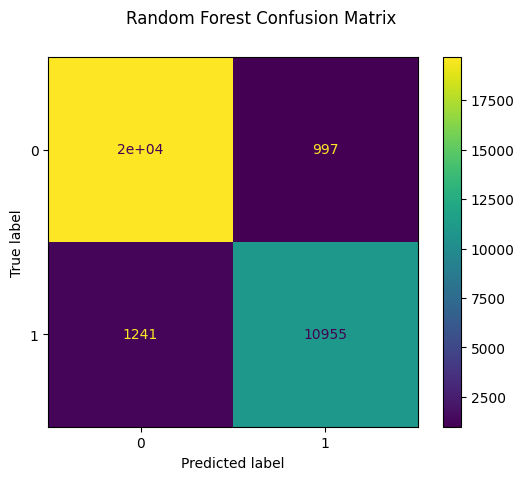

In [62]:
# Random Forest Confusion Matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, rf_y_pred)
disp.figure_.suptitle("Random Forest Confusion Matrix")

plt.show()

In [221]:
# Grid Search XGB
xgb_params = {'n_estimators': [100, 200, 300],'max_depth': [3, 6, 10, 20], 'learning_rate': [0.1, 0.2, 0.3]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=3)
xgb_grid.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1, 0.2, ...], 'max_depth': [3, 6, ...], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [222]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}

In [47]:
# Train XGBoost Model
xgb_model = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [48]:
# Predictions and evaluation
xgb_y_pred = xgb_model.predict(X_test)

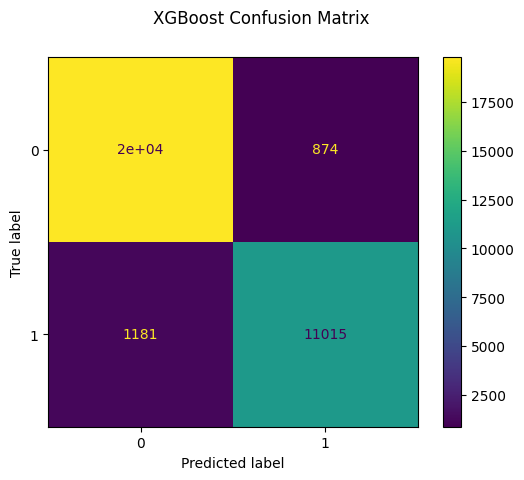

In [63]:
# XGBoost Confusion Matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, xgb_y_pred)
disp.figure_.suptitle("XGBoost Confusion Matrix")

plt.show()

In [ ]:
# Grid Search MLP
mlp_params = {'hidden_layer_sizes': [(100,), (200,), (100, 50), (200,50)], 'alpha': [0.001, 0.01]}
mlp_grid = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), mlp_params, cv=3)
mlp_grid.fit(X_train, y_train)

In [ ]:
mlp_grid.best_params_

In [196]:
mlp_grid.best_score_

np.float64(0.85035105957951)

In [19]:
# Train Multi Layer Perceptron Model
mlp_model = MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=1000 ,random_state=42)
mlp_model.fit(X_train, y_train)

,hidden_layer_sizes,"(200, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


In [20]:
# Predictions and evaluation
mlp_y_pred = mlp_model.predict(X_test)

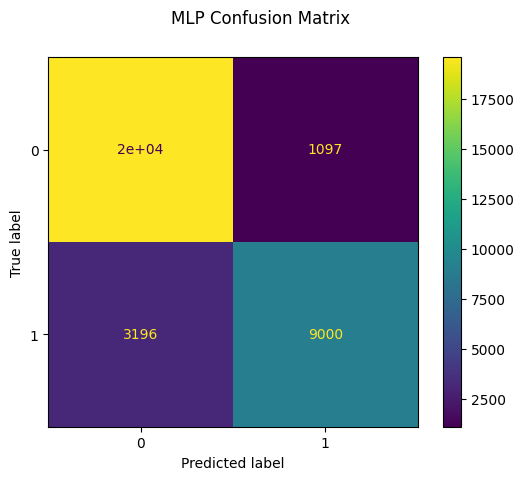

In [64]:
# MLP Confusion Matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, mlp_y_pred)
disp.figure_.suptitle("MLP Confusion Matrix")

plt.show()

In [172]:
# Grid Search LReg
lreg_params = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
lreg_grid = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), lreg_params, cv=3)
lreg_grid.fit(X_train, y_train)

,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.1, 1, ...], 'penalty': ['l1', 'l2']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [185]:
lreg_grid.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [186]:
lreg_grid.best_score_

np.float64(0.801317701628875)

In [21]:
# Train Logistic Regression model
lreg_model = LogisticRegression(solver='liblinear', C= 0.1, penalty='l1',  max_iter=1000, random_state=42)
lreg_model.fit(X_train, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [22]:
# Predictions and evaluation
lreg_y_pred = lreg_model.predict(X_test)

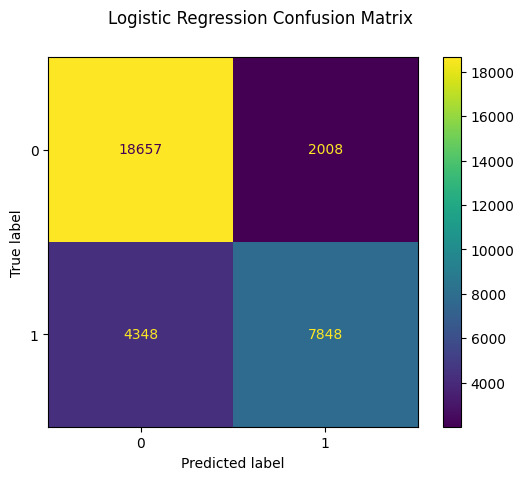

In [65]:
# LREG Confusion Matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, lreg_y_pred)
disp.figure_.suptitle("Logistic Regression Confusion Matrix")

plt.show()

## Implementing LIME

In [27]:
# Initialize LIME explainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_columns, 
                                 class_names=['Legitimate', 'Phishing'],
                                 mode='classification')


C:\Users\chris_1tizw4h\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


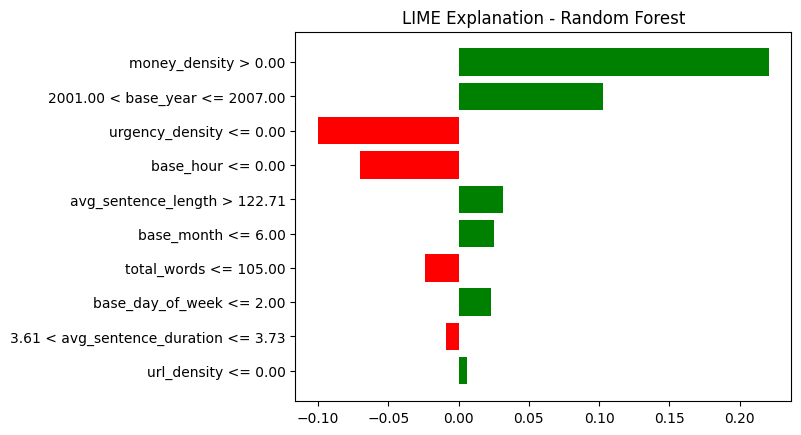

In [28]:
# Generate explanation for an email instance
instance = X_test.iloc[0].values
exp = explainer.explain_instance(instance, rf_model.predict_proba, num_features=10)

# Creating the graph
fig = exp.as_pyplot_figure()
plt.title('LIME Explanation - Random Forest')
plt.show()

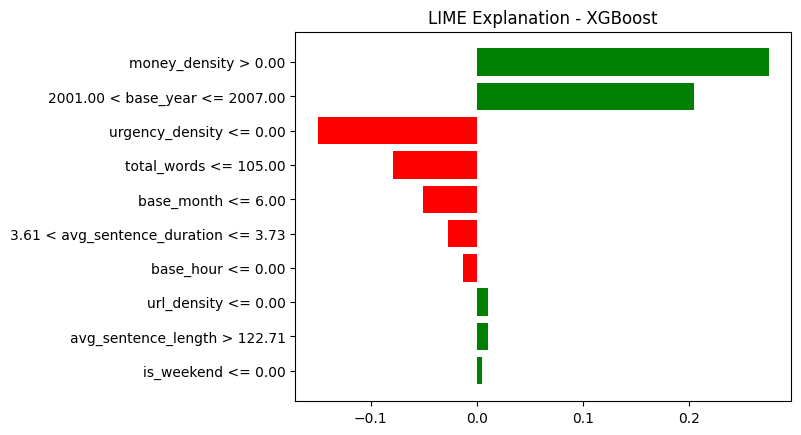

In [29]:
# Generate explanation for a specific instance
instance = X_test.iloc[0].values
exp = explainer.explain_instance(instance, xgb_model.predict_proba, num_features=10)

# Create the graph
fig = exp.as_pyplot_figure()
plt.title('LIME Explanation - XGBoost')
plt.show()

C:\Users\chris_1tizw4h\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


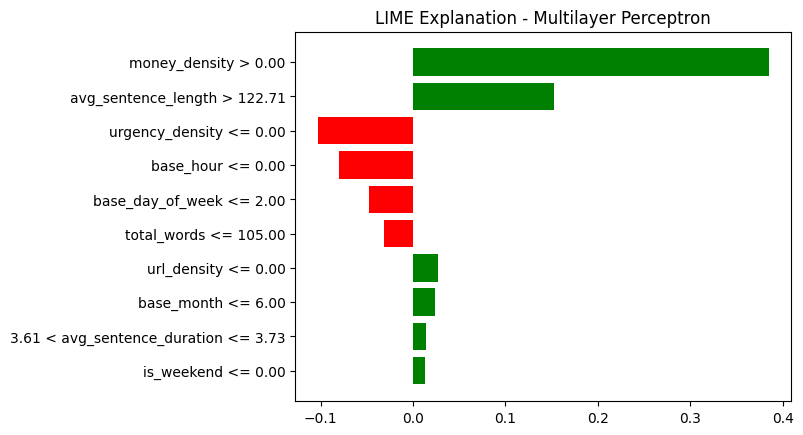

In [30]:
# Generate explanation for a specific instance
instance = X_test.iloc[0].values
exp = explainer.explain_instance(instance, mlp_model.predict_proba, num_features=10)

# Create the graph
fig = exp.as_pyplot_figure()
plt.title('LIME Explanation - Multilayer Perceptron')
plt.show()

C:\Users\chris_1tizw4h\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


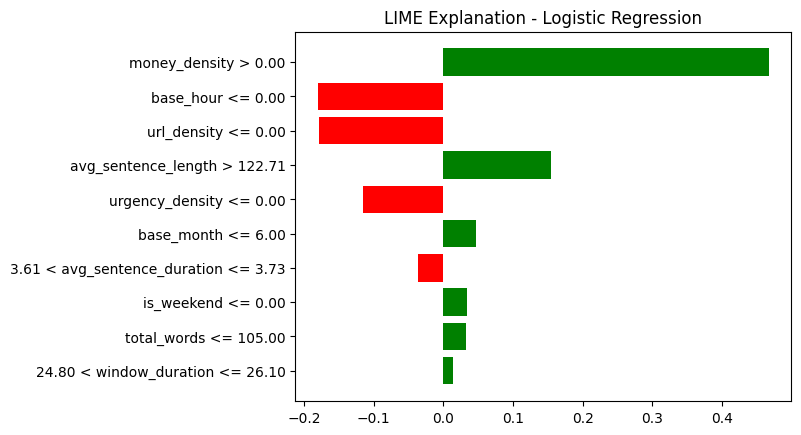

In [31]:
# Generate explanation for a specific instance
instance = X_test.iloc[0].values
exp = explainer.explain_instance(instance, lreg_model.predict_proba, num_features=10)

# Create the graph
fig = exp.as_pyplot_figure()
plt.title('LIME Explanation - Logistic Regression')
plt.show()

## SHAP Explanations

In [26]:
#Convert all features to float64 for shap
X_num = X.astype('float64')

In [43]:
# SHAP explainer and values for RF
rf_explainer = shap.Explainer(rf_model)
rf_shap_values = rf_explainer(X[0:10000])

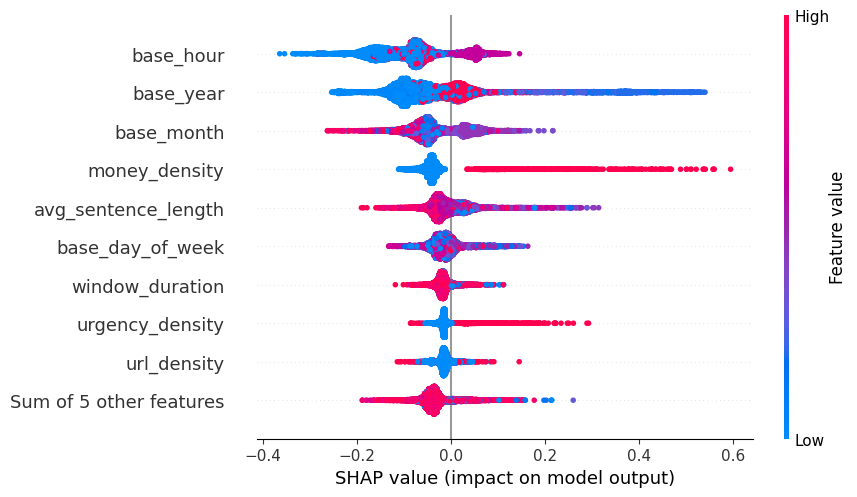

In [45]:
# Beeswarm PLot for RF
shap.plots.beeswarm(rf_shap_values[:, :, 1])

In [40]:
# SHAP explainer and values for XGB
xgb_explainer = shap.Explainer(xgb_model, X_num[:10000],model_output="probability")
xgb_shap_values = xgb_explainer(X_num[0:10000])

100%|===================| 9970/10000 [02:33<00:00]        

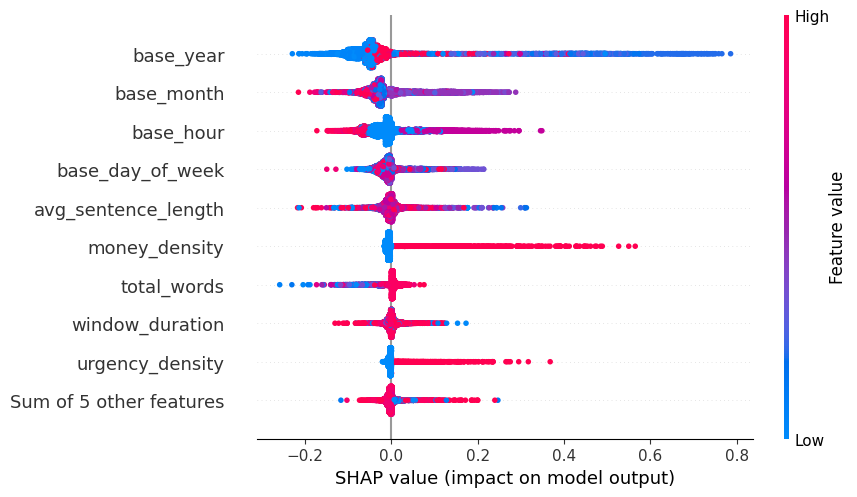

In [46]:
# Beeswarm plot for XGB
shap.plots.beeswarm(xgb_shap_values)

In [49]:
# SHAP explainer and values for MLP
mlp_explainer = shap.Explainer(mlp_model.predict, X_num[:10000])
mlp_shap_values = mlp_explainer(X_num[0:10000])

PermutationExplainer explainer: 10001it [04:35, 36.05it/s]                                                             


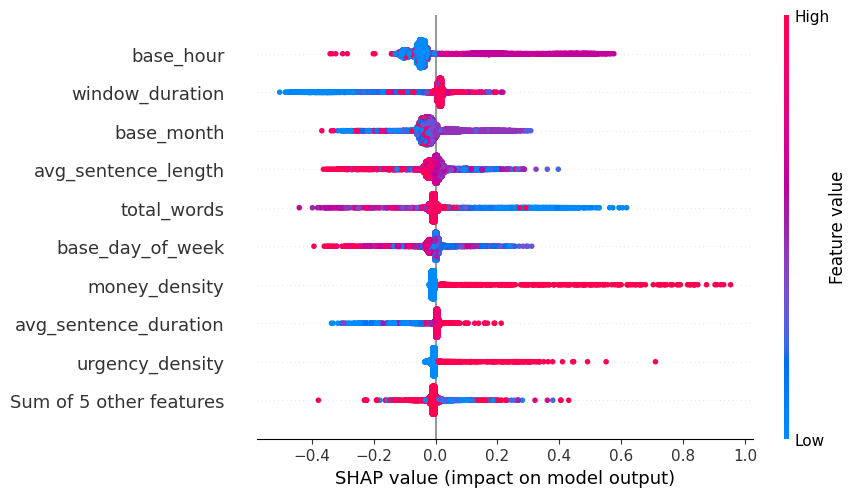

In [50]:
# Beeswarm Plot for MLP
shap.plots.beeswarm(mlp_shap_values)

In [51]:
# SHAP explainer and values for LREG
lreg_explainer = shap.Explainer(lreg_model.predict, X_num[:10000])
lreg_shap_values = lreg_explainer(X_num[:10000])

PermutationExplainer explainer: 10001it [01:36, 93.07it/s]                                                             


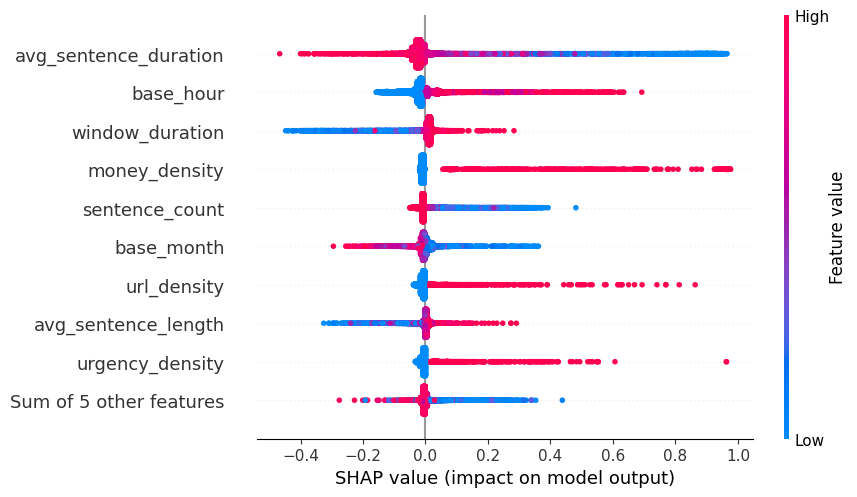

In [52]:
# Beeswarm plot for LReg
shap.plots.beeswarm(lreg_shap_values)

## Evaluaton Metrics

In [49]:
#Classification report for Random Forest 
print(
    f"Classification report for classifier {rf_model}:\n"
    f"{metrics.classification_report(y_test, rf_y_pred, zero_division=0)}\n"
)

Classification report for classifier RandomForestClassifier(n_estimators=200, random_state=42):
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     20665
           1       0.92      0.90      0.91     12196

    accuracy                           0.93     32861
   macro avg       0.93      0.92      0.93     32861
weighted avg       0.93      0.93      0.93     32861




In [50]:
#Classification report for XGBooost
print(
    f"Classification report for classifier {xgb_model}:\n"
    f"{metrics.classification_report(y_test, xgb_y_pred, zero_division=0)}\n"
)

Classification report for classifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     20665
           1       0.93      0.90      0.91     12196

    accuracy                           0.

In [55]:
#Classification report for Multilayer Perception
print(
    f"Classification report for classifier {mlp_model}:\n"
    f"{metrics.classification_report(y_test, mlp_y_pred, zero_division=0)}\n"
)

Classification report for classifier MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=1000, random_state=42):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     20665
           1       0.89      0.74      0.81     12196

    accuracy                           0.87     32861
   macro avg       0.88      0.84      0.85     32861
weighted avg       0.87      0.87      0.87     32861




In [56]:
#Classification report for LREg
print(
    f"Classification report for classifier {lreg_model}:\n"
    f"{metrics.classification_report(y_test, lreg_y_pred, zero_division=0)}\n"
)

Classification report for classifier LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear'):
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     20665
           1       0.80      0.64      0.71     12196

    accuracy                           0.81     32861
   macro avg       0.80      0.77      0.78     32861
weighted avg       0.81      0.81      0.80     32861


